In [12]:
# Importar bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
import time

# Métricas y procesamiento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


In [13]:
# Verificar disponibilidad de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUtilizando: {device}")


Utilizando: cpu


In [14]:
# PASO 1: Cargar dataset
print("\nPASO 1: Cargando el dataset")
combined_clean_path = "/content/fake_news_combined_clean.csv"
try:
    df = pd.read_csv(combined_clean_path)
    print(f"Dataset cargado con {df.shape[0]} registros y {df.shape[1]} columnas.")
except Exception as e:
    print(f"Error al cargar el dataset: {e}")
    print("Asegúrate de que 'fake_news_combined_clean.csv' está en la carpeta /content/")
    raise


PASO 1: Cargando el dataset
Dataset cargado con 4349 registros y 6 columnas.


In [15]:
# Ver distribución de clases
print("\nDistribución de clases:")
class_dist = df['label'].value_counts()
display(class_dist)

# Convertir etiquetas a formato numérico
print("Convirtiendo etiquetas a formato numérico...")
if df['label'].dtype == 'object':
    # Detectar nombres de etiquetas
    label_unique = df['label'].unique()
    print(f"Etiquetas únicas encontradas: {label_unique}")

    # Mapeo de etiquetas de texto a números
    label_map = {}
    for label in label_unique:
        if any(word in str(label).lower() for word in ['falsa', 'fake', 'false']):
            label_map[label] = 0  # Falsa = 0
        else:
            label_map[label] = 1  # Verdadera = 1

    # Aplicar mapeo
    df['label_num'] = df['label'].map(label_map)
else:
    # Si ya es numérica, asegurar valores binarios
    df['label_num'] = df['label'].apply(lambda x: 1 if x > 0 else 0)

# Verificar conversión
print("\nDistribución después del mapeo:")
label_num_dist = df['label_num'].value_counts()
display(label_num_dist)


Distribución de clases:


,count
label,
Verdadera,2847
Falsa,1502


Convirtiendo etiquetas a formato numérico...
Etiquetas únicas encontradas: ['Falsa' 'Verdadera']

Distribución después del mapeo:


,count
label_num,
1,2847
0,1502


In [16]:
# PASO 2: Preprocesamiento y extracción de características
print("\nPASO 2: Preprocesamiento y extracción de características")

# Función de preprocesamiento básico
def preprocess_text(text):
    """Preprocesamiento básico del texto."""
    if isinstance(text, str):
        # Convertir a minúsculas
        text = text.lower()

        # Eliminar URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Eliminar etiquetas HTML
        text = re.sub(r'<.*?>', '', text)

        # Eliminar espacios múltiples
        text = re.sub(r'\s+', ' ', text).strip()

        return text
    return ""

# Utilizar una muestra para desarrollo
sample_size = min(10000, len(df))  # Usar una muestra más grande
print(f"\nUsando una muestra de {sample_size} registros...")
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Preprocesar texto
print("Preprocesando textos...")
df_sample['clean_title'] = df_sample['title'].apply(preprocess_text)
df_sample['clean_content'] = df_sample['content'].apply(
    lambda x: preprocess_text(x[:1000]) if isinstance(x, str) else ""
)

# Extraer características lingüísticas básicas
print("Extrayendo características lingüísticas...")

def extract_linguistic_features(row):
    """Extrae características lingüísticas del texto."""
    title = row['clean_title']
    content = row['clean_content']

    features = {}

    # Características de longitud
    features['title_length'] = len(title) if isinstance(title, str) else 0
    features['title_word_count'] = len(title.split()) if isinstance(title, str) else 0
    features['content_length'] = len(content) if isinstance(content, str) else 0
    features['content_word_count'] = len(content.split()) if isinstance(content, str) else 0

    # Características de puntuación
    features['title_exclamation_count'] = title.count('!') if isinstance(title, str) else 0
    features['title_question_count'] = title.count('?') if isinstance(title, str) else 0
    features['content_exclamation_count'] = content.count('!') if isinstance(content, str) else 0
    features['content_question_count'] = content.count('?') if isinstance(content, str) else 0

    # Palabras sensacionalistas comunes en fake news
    sensational_words = ['increíble', 'impactante', 'asombroso', 'urgente', 'viral',
                         'escándalo', 'secreto', 'exclusiva', 'prohibido', 'censurado']

    title_lower = title.lower() if isinstance(title, str) else ""
    content_lower = content.lower() if isinstance(content, str) else ""

    features['title_sensational_count'] = sum(1 for word in sensational_words if word in title_lower)
    features['content_sensational_count'] = sum(1 for word in sensational_words if word in content_lower)

    # Presencia de números
    features['title_number_count'] = len(re.findall(r'\d+', title)) if isinstance(title, str) else 0
    features['content_number_count'] = len(re.findall(r'\d+', content)) if isinstance(content, str) else 0

    # Uso de mayúsculas
    features['title_uppercase_ratio'] = sum(1 for c in title if c.isupper()) / len(title) if isinstance(title, str) and len(title) > 0 else 0

    return pd.Series(features)

# Extraer características lingüísticas
linguistic_features = df_sample.apply(extract_linguistic_features, axis=1)
df_features = pd.concat([df_sample, linguistic_features], axis=1)

# Combinar título y contenido (con más peso al título)
df_features['combined_text'] = df_features['clean_title'] + " " + df_features['clean_title'] + " " + df_features['clean_content']



PASO 2: Preprocesamiento y extracción de características

Usando una muestra de 4349 registros...
Preprocesando textos...
Extrayendo características lingüísticas...


In [17]:
# PASO 3: Construir un modelo híbrido
print("\nPASO 3: Construyendo modelo híbrido con TF-IDF y características lingüísticas")

# Dividir en conjuntos de entrenamiento y prueba
X_text_train, X_text_test, X_features_train, X_features_test, y_train, y_test = train_test_split(
    df_features['combined_text'],
    df_features[linguistic_features.columns],
    df_features['label_num'],
    test_size=0.2,
    random_state=42,
    stratify=df_features['label_num']
)

print(f"Conjunto de entrenamiento: {len(X_text_train)} muestras")
print(f"Conjunto de prueba: {len(X_text_test)} muestras")

# Configurar el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.85
)

# Entrenar y transformar los datos de texto
print("Aplicando TF-IDF al texto...")
X_text_train_tfidf = tfidf_vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = tfidf_vectorizer.transform(X_text_test)

# Convertir características lingüísticas a matrices numpy
X_features_train_np = X_features_train.values
X_features_test_np = X_features_test.values

# Combinar TF-IDF y características lingüísticas
print("Combinando TF-IDF con características lingüísticas...")
X_train_combined = np.hstack((
    X_text_train_tfidf.toarray(),
    X_features_train_np
))

X_test_combined = np.hstack((
    X_text_test_tfidf.toarray(),
    X_features_test_np
))

print(f"Matriz de características combinadas: {X_train_combined.shape}")


PASO 3: Construyendo modelo híbrido con TF-IDF y características lingüísticas
Conjunto de entrenamiento: 3479 muestras
Conjunto de prueba: 870 muestras
Aplicando TF-IDF al texto...
Combinando TF-IDF con características lingüísticas...
Matriz de características combinadas: (3479, 15013)


In [18]:
# PASO 4: Entrenar un clasificador
print("\nPASO 4: Entrenando el modelo combinado")

# Crear y entrenar modelo de regresión logística
model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)

print("Entrenando modelo...")
start_time = time.time()
model.fit(X_train_combined, y_train)
training_time = time.time() - start_time
print(f"Entrenamiento completado en {training_time:.2f} segundos")

# Evaluar en conjunto de prueba
y_pred = model.predict(X_test_combined)
y_prob = model.predict_proba(X_test_combined)[:, 1]  # Probabilidad de la clase positiva


PASO 4: Entrenando el modelo combinado
Entrenando modelo...
Entrenamiento completado en 2.51 segundos



PASO 5: Evaluando el modelo

Precisión: 0.7862

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       300
           1       0.88      0.78      0.83       570

    accuracy                           0.79       870
   macro avg       0.77      0.79      0.77       870
weighted avg       0.80      0.79      0.79       870



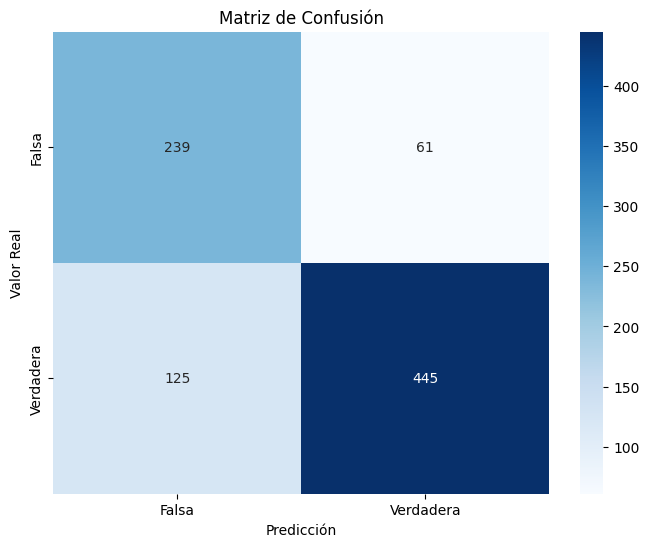

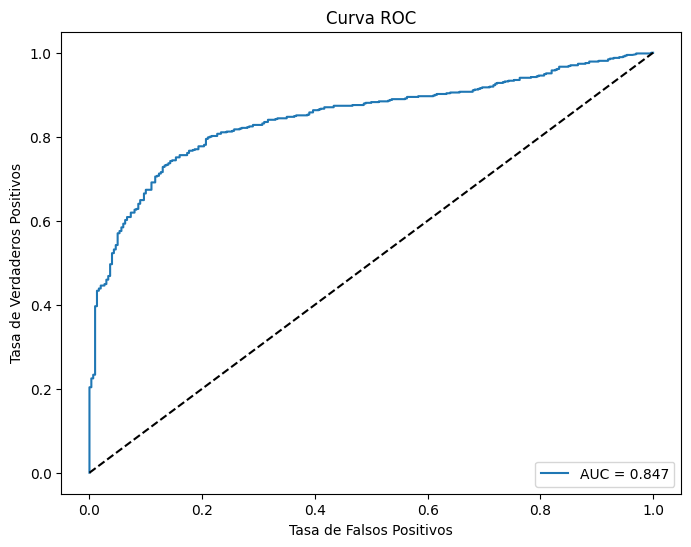

In [19]:
# PASO 5: Evaluar el modelo
print("\nPASO 5: Evaluando el modelo")

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión: {accuracy:.4f}")

# Mostrar informe detallado
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks([0.5, 1.5], ['Falsa', 'Verdadera'])
plt.yticks([0.5, 1.5], ['Falsa', 'Verdadera'])
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()



PASO 6: Analizando las características más importantes
20 características más importantes:


,Feature,Importance,Abs_Importance
14255,true content,4.408950,4.408950
11782,prediction true,4.408950,4.408950
11783,prediction true content,4.408950,4.408950
14254,true,4.380545,4.380545
11781,prediction fake content,-3.905615,3.905615
6392,fake content,-3.905615,3.905615
11780,prediction fake,-3.905615,3.905615
6391,fake,-3.876783,3.876783
10196,mundo prediction fake,-2.762723,2.762723
9049,ley,-1.748528,1.748528


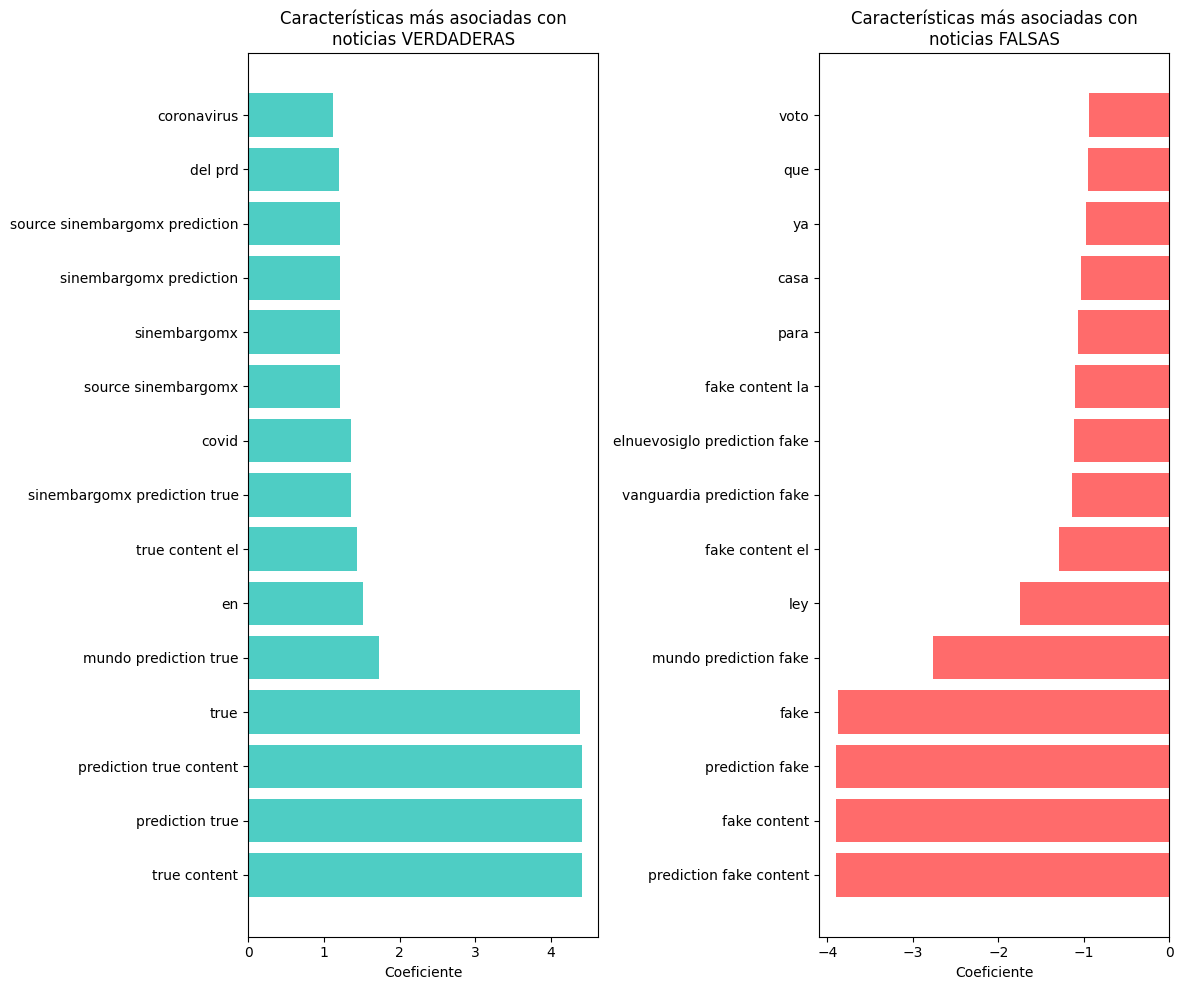

In [20]:
# PASO 6: Análisis de características importantes
print("\nPASO 6: Analizando las características más importantes")

# Obtener coeficientes del modelo
coefficients = model.coef_[0]

# Obtener nombres de características
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
all_feature_names = np.concatenate([tfidf_feature_names, linguistic_features.columns])

# Crear un DataFrame con características y sus coeficientes
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': coefficients
})

# Ordenar por importancia absoluta
feature_importance['Abs_Importance'] = np.abs(feature_importance['Importance'])
feature_importance = feature_importance.sort_values('Abs_Importance', ascending=False)

# Mostrar las 20 características más importantes
print("20 características más importantes:")
display(feature_importance.head(20))

# Visualizar las características más importantes
plt.figure(figsize=(12, 10))

# Características positivas (asociadas con noticias verdaderas)
positive_features = feature_importance[feature_importance['Importance'] > 0].head(15)
plt.subplot(1, 2, 1)
plt.barh(positive_features['Feature'], positive_features['Importance'], color='#4ECDC4')
plt.title('Características más asociadas con\nnoticias VERDADERAS', fontsize=12)
plt.xlabel('Coeficiente')

# Características negativas (asociadas con noticias falsas)
negative_features = feature_importance[feature_importance['Importance'] < 0].head(15)
plt.subplot(1, 2, 2)
plt.barh(negative_features['Feature'], negative_features['Importance'], color='#FF6B6B')
plt.title('Características más asociadas con\nnoticias FALSAS', fontsize=12)
plt.xlabel('Coeficiente')

plt.tight_layout()
plt.show()

In [21]:
# PASO 7: Crear función para detectar fake news
print("\nPASO 7: Función para detectar fake news")

def detect_fake_news(title, content=""):
    """
    Detecta si una noticia es falsa o verdadera.

    Args:
        title (str): Título de la noticia
        content (str): Contenido de la noticia (opcional)

    Returns:
        tuple: (resultado, confianza)
    """
    # Preprocesar textos
    clean_title = preprocess_text(title)
    clean_content = preprocess_text(content[:1000] if content else "")

    # Combinar texto (dando más peso al título)
    combined_text = clean_title + " " + clean_title + " " + clean_content

    # Extraer características lingüísticas
    features = {}

    # Características de longitud
    features['title_length'] = len(clean_title)
    features['title_word_count'] = len(clean_title.split())
    features['content_length'] = len(clean_content)
    features['content_word_count'] = len(clean_content.split())

    # Características de puntuación
    features['title_exclamation_count'] = clean_title.count('!')
    features['title_question_count'] = clean_title.count('?')
    features['content_exclamation_count'] = clean_content.count('!')
    features['content_question_count'] = clean_content.count('?')

    # Palabras sensacionalistas
    sensational_words = ['increíble', 'impactante', 'asombroso', 'urgente', 'viral',
                        'escándalo', 'secreto', 'exclusiva', 'prohibido', 'censurado']

    features['title_sensational_count'] = sum(1 for word in sensational_words if word in clean_title.lower())
    features['content_sensational_count'] = sum(1 for word in sensational_words if word in clean_content.lower())

    # Presencia de números
    features['title_number_count'] = len(re.findall(r'\d+', clean_title))
    features['content_number_count'] = len(re.findall(r'\d+', clean_content))

    # Uso de mayúsculas
    features['title_uppercase_ratio'] = sum(1 for c in title if c.isupper()) / max(1, len(title))

    # Convertir a vector
    text_vector = tfidf_vectorizer.transform([combined_text])

    # Crear vector de características
    features_vector = np.array([features[col] for col in linguistic_features.columns]).reshape(1, -1)

    # Combinar vectores
    combined_vector = np.hstack((text_vector.toarray(), features_vector))

    # Predecir
    prediction = model.predict(combined_vector)[0]
    probability = model.predict_proba(combined_vector)[0]

    # Resultados
    result = "Verdadera" if prediction == 1 else "Falsa"
    confidence = probability[1] if prediction == 1 else probability[0]

    return result, confidence


PASO 7: Función para detectar fake news


In [26]:
# Probar con ejemplos
print("\nProbando el detector con ejemplos:")

# Ejemplo 1: Una noticia del conjunto de prueba
example_idx = 7
example_title = df_sample.loc[example_idx, 'title']
example_content = df_sample.loc[example_idx, 'content']
true_label = "Verdadera" if df_sample.loc[example_idx, 'label_num'] == 1 else "Falsa"

print("\nEJEMPLO 1:")
print(f"Título: {example_title}")
print(f"Contenido (extracto): {example_content[:100] if isinstance(example_content, str) else ''}...")
print(f"Etiqueta real: {true_label}")

result, confidence = detect_fake_news(example_title, example_content)
print(f"Predicción: {result}")
print(f"Confianza: {confidence:.4f}")




Probando el detector con ejemplos:

EJEMPLO 1:
Título: ¿Qué ordena la Sala al Gobierno por el atraso de salarios en la Asamblea de El Salvador?
Contenido (extracto): Source:El Mundo

 Prediction:True

 Content:
Un grupo de trabajadores interpusieron una demanda ante...
Etiqueta real: Verdadera
Predicción: Verdadera
Confianza: 0.7491
